# **Capstone Project - Tastes of Osaka**


This is the notebook for Applied Data Science Capstone. Many thanks for your review!

Link for the report: [Report](https://github.com/Zi-Ao-Huang/IBM_capstone_project/blob/master/Capstone_Report.pdf)

Link for the presentation: [Presentation](https://github.com/Zi-Ao-Huang/IBM_capstone_project/blob/master/Capstone_Presentation.pdf)


### Data collection and preparation

Import libraries

In [0]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
import json
import random
from geopy.geocoders import Nominatim
import requests
from bs4 import BeautifulSoup 
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from folium import plugins
import os
from IPython.display import Image 
from IPython.core.display import HTML
from sklearn.metrics import silhouette_score
from collections import Counter
%config InlineBackend.figure_format = 'retina'
print('Libraries imported.')

Libraries imported.


Scraping postal codes of Osaka

In [0]:
japan = requests.get('https://en.wikipedia.org/wiki/Wards_of_Japan').text
soup = BeautifulSoup(japan,'lxml')
japan_table = soup.find('table', {'class':'wikitable sortable'})
column_names = ['Wards','Kanji','City','Area']
df = pd.DataFrame(columns=column_names)
df.head()

,Wards,Kanji,City,Area


In [0]:
for tr_cell in japan_table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==4:
        df.loc[len(df)] = row_data
df=df[df['City'].isin(['Osaka'])]
print(df.shape)
df.head()

(24, 4)


,Wards,Kanji,City,Area
95,Abeno,阿倍野区,Osaka,5.98
96,Asahi,旭区,Osaka,6.32
97,Chūō,中央区,Osaka,8.87
98,Fukushima,福島区,Osaka,4.67
99,Higashinari,東成区,Osaka,4.54


Get the geographical coordinates of Wards in Osaka.

In [0]:
df["new"] = df['Wards'] + '-ku, Osaka' #Creat a new column with '-ku, Osaka' added to the ward names to increase the accuracy for coordinates results.
geolocator = Nominatim(user_agent="Osaka_explorer")
df['Major_Dist_Coord']= df['new'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df[['Latitude', 'Longitude']] = df['Major_Dist_Coord'].apply(pd.Series)

df.drop(['Major_Dist_Coord','new'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.head(24)

(24, 6)


,Wards,Kanji,City,Area,Latitude,Longitude
0,Abeno,阿倍野区,Osaka,5.98,34.627501,135.514095
1,Asahi,旭区,Osaka,6.32,34.726483,135.546952
2,Chūō,中央区,Osaka,8.87,34.679846,135.510316
3,Fukushima,福島区,Osaka,4.67,34.692104,135.474812
4,Higashinari,東成区,Osaka,4.54,34.672912,135.550567
5,Higashisumiyoshi,東住吉区,Osaka,9.75,34.615662,135.531096
6,Higashiyodogawa,東淀川区,Osaka,13.27,34.740212,135.517432
7,Hirano,平野区,Osaka,15.28,34.603715,135.559027
8,Ikuno,生野区,Osaka,8.37,34.653003,135.547722
9,Joto,城東区,Osaka,8.38,34.693887,135.547769


In [0]:
# save the DataFrame as CSV file
df.to_csv("osaka_df.csv", index=False)

In [0]:
osaka_df = pd.read_csv("osaka_df.csv")
osaka_df.drop(columns=["City"],inplace=True)
osaka_df.head()

,Wards,Kanji,Area,Latitude,Longitude
0,Abeno,阿倍野区,5.98,34.627501,135.514095
1,Asahi,旭区,6.32,34.726483,135.546952
2,Chūō,中央区,8.87,34.679846,135.510316
3,Fukushima,福島区,4.67,34.692104,135.474812
4,Higashinari,東成区,4.54,34.672912,135.550567


Create a map of Osaka with wards superimposed on top

In [0]:
address = 'Chūōku, Osaka'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
lat_chuoku = location.latitude
lon_chuoku = location.longitude

In [0]:
map_osaka = folium.Map(location=[lat_chuoku, lon_chuoku], zoom_start=12) #using the coordinates of Chūōku to create the map, providing the best view of Osaka

mark_ward = folium.map.FeatureGroup()
for lat, lng, label in zip(osaka_df['Latitude'],osaka_df['Longitude'],osaka_df['Wards']):
    mark_ward.add_child(
    folium.CircleMarker(
        [lat, lng],
        radius=15,
        popup=label,
        color='white',
        fill_color='#3183cc',
        fill_opacity=0.3
        )
    )


map_osaka.add_child(mark_ward)

![OsakaMap](https://raw.githubusercontent.com/Zi-Ao-Huang/IBM_capstone_project/master/Capstone_figure/map_osaka.jpg)

Define Foursquare Credentials and Version

In [0]:
CLIENT_ID = 'LCB1PXFFN0RYEONQAASUFW1RS0VWXQJEQM5JJCKT15VMJVPC'
CLIENT_SECRET = 'OLNEHS3UZSZJVM43F4FBH3BLA4T0VDLPFNY1RAY5TDUD4ZKV'
VERSION = '20200505'
LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 1700 # define radius, some of the areas are too close so we will use the 1.7km as radius

Create a function to get the nearby venues for all wards in Osaka

In [0]:
def getNearbyVenues(names, latitudes, longitudes):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Ward', 
                  'Ward_Latitude', 
                  'Ward_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues)

In [0]:
Osaka_venues = getNearbyVenues(names=osaka_df['Wards'],
                               latitudes=osaka_df['Latitude'],
                               longitudes=osaka_df['Longitude']
                               )

Abeno
Asahi
Chūō
Fukushima
Higashinari
Higashisumiyoshi
Higashiyodogawa
Hirano
Ikuno
Joto
Kita
Konohana
Minato
Miyakojima
Naniwa
Nishi
Nishinari
Nishiyodogawa
Suminoe
Sumiyoshi
Taishō
Tennōji
Tsurumi
Yodogawa


In [0]:
print(Osaka_venues.shape)
Osaka_venues.head()

(2263, 7)


,Ward,Ward_Latitude,Ward_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Abeno,34.627501,135.514095,Usagi to Boku (うさぎとぼく),34.629734,135.515104,Coffee Shop
1,Abeno,34.627501,135.514095,桃ヶ池公園,34.631239,135.521659,Park
2,Abeno,34.627501,135.514095,スタンドアサヒ,34.625118,135.520530,Sake Bar
3,Abeno,34.627501,135.514095,ライフ セントラルスクエア 北畠店,34.626273,135.509131,Supermarket
4,Abeno,34.627501,135.514095,Gogh (石窯パンの店 ゴッホ),34.621037,135.522307,Bakery


In [0]:
Osaka_venues.to_csv('Osaka_venues.csv')
from google.colab import files
files.download("Osaka_venues.csv")

Create a data frame with **Restaurant**.

In [0]:
Osaka_restaurant = Osaka_venues[Osaka_venues['Venue_Category'].str.contains('Restaurant')].reset_index(drop=True)
Osaka_restaurant.index = np.arange(1, len(Osaka_restaurant)+1)
Osaka_restaurant.reset_index(drop=True, inplace=True)
print(Osaka_restaurant.shape)
Osaka_restaurant.head()

(622, 7)


,Ward,Ward_Latitude,Ward_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Abeno,34.627501,135.514095,ハンバーグレストラン BOSTON 昭和町本店,34.632831,135.516725,American Restaurant
1,Abeno,34.627501,135.514095,Men to Kokoro 7 (麺と心 7),34.639715,135.511143,Ramen Restaurant
2,Abeno,34.627501,135.514095,Royal Host (ロイヤルホスト 文の里店),34.637175,135.517652,Restaurant
3,Abeno,34.627501,135.514095,甘辛や,34.638189,135.522473,Okonomiyaki Restaurant
4,Abeno,34.627501,135.514095,さん天 あべの万代店,34.620353,135.505904,Tempura Restaurant


Investigate the restaurant categories.

In [0]:
print('There are {} unique categories.'.format(len(Osaka_restaurant['Venue_Category'].unique())))
print (Osaka_restaurant['Venue_Category'].value_counts())

There are 42 unique categories.
Ramen Restaurant             109
Chinese Restaurant            60
Japanese Restaurant           56
Japanese Curry Restaurant     45
Donburi Restaurant            44
Fast Food Restaurant          40
Sushi Restaurant              37
Restaurant                    30
Udon Restaurant               29
Italian Restaurant            23
Okonomiyaki Restaurant        17
Kushikatsu Restaurant         11
Yoshoku Restaurant            10
Indian Restaurant              9
American Restaurant            8
Soba Restaurant                8
Asian Restaurant               7
Yakitori Restaurant            6
Dumpling Restaurant            6
Sri Lankan Restaurant          6
Thai Restaurant                5
Korean Restaurant              5
Tonkatsu Restaurant            5
Mexican Restaurant             5
Seafood Restaurant             5
Tempura Restaurant             5
Dim Sum Restaurant             4
Spanish Restaurant             3
Nabe Restaurant                3
Unagi Resta

In [0]:
print (Osaka_restaurant['Ward'].value_counts())

Fukushima           49
Chūō                42
Yodogawa            38
Nishi               36
Kita                35
Miyakojima          35
Naniwa              33
Tennōji             30
Joto                27
Higashinari         27
Tsurumi             25
Asahi               25
Nishinari           23
Higashisumiyoshi    22
Higashiyodogawa     22
Ikuno               22
Suminoe             22
Hirano              21
Abeno               19
Sumiyoshi           18
Minato              17
Taishō              14
Nishiyodogawa       13
Konohana             7
Name: Ward, dtype: int64


## Data analysis and visualization

Analyze the restaurant and venue categories in Osaka

In [0]:
osaka_onehot = pd.get_dummies(Osaka_restaurant[['Venue_Category']], prefix="", prefix_sep="")
osaka_onehot['Ward'] = Osaka_restaurant['Ward'] 
ward = osaka_onehot['Ward']
osaka_onehot.drop(labels=['Ward'], axis=1,inplace = True)
osaka_onehot.insert(0, 'Ward', ward)
restaurant_counts = osaka_onehot.groupby('Ward').sum()
restaurant_counts_described = restaurant_counts.describe().transpose()
restaurant_top6 = restaurant_counts_described.sort_values('mean', ascending=False)[0:6]
restaurant_top6

,count,mean,std,min,25%,50%,75%,max
Ramen Restaurant,24.0,4.541667,3.833255,0.0,2.75,3.5,5.00,15.0
Chinese Restaurant,24.0,2.500000,1.817787,0.0,1.00,2.0,4.00,7.0
Japanese Restaurant,24.0,2.333333,1.761093,0.0,1.00,2.0,3.00,6.0
Japanese Curry Restaurant,24.0,1.875000,2.309009,0.0,0.75,1.0,2.25,11.0
Donburi Restaurant,24.0,1.833333,1.785611,0.0,0.00,1.0,3.25,5.0
Fast Food Restaurant,24.0,1.666667,1.239448,0.0,0.75,2.0,3.00,4.0


In [0]:
osaka2_onehot = pd.get_dummies(Osaka_venues[['Venue_Category']], prefix="", prefix_sep="")
osaka2_onehot['Ward'] = Osaka_venues['Ward'] 
ward = osaka2_onehot['Ward']
osaka2_onehot.drop(labels=['Ward'], axis=1,inplace = True)
osaka2_onehot.insert(0, 'Ward', ward)
venue_counts = osaka2_onehot.groupby('Ward').sum()
venue_counts_described = venue_counts.describe().transpose()
venue_top6 = venue_counts_described.sort_values('mean', ascending=False)[0:6]
venue_top6

,count,mean,std,min,25%,50%,75%,max
Convenience Store,24.0,24.791667,16.901194,0.0,10.75,28.0,39.25,49.0
Ramen Restaurant,24.0,4.541667,3.833255,0.0,2.75,3.5,5.00,15.0
Sake Bar,24.0,2.583333,2.041241,0.0,1.00,2.0,3.25,9.0
Chinese Restaurant,24.0,2.500000,1.817787,0.0,1.00,2.0,4.00,7.0
Japanese Restaurant,24.0,2.333333,1.761093,0.0,1.00,2.0,3.00,6.0
Supermarket,24.0,2.166667,1.659404,0.0,1.00,2.0,3.00,6.0


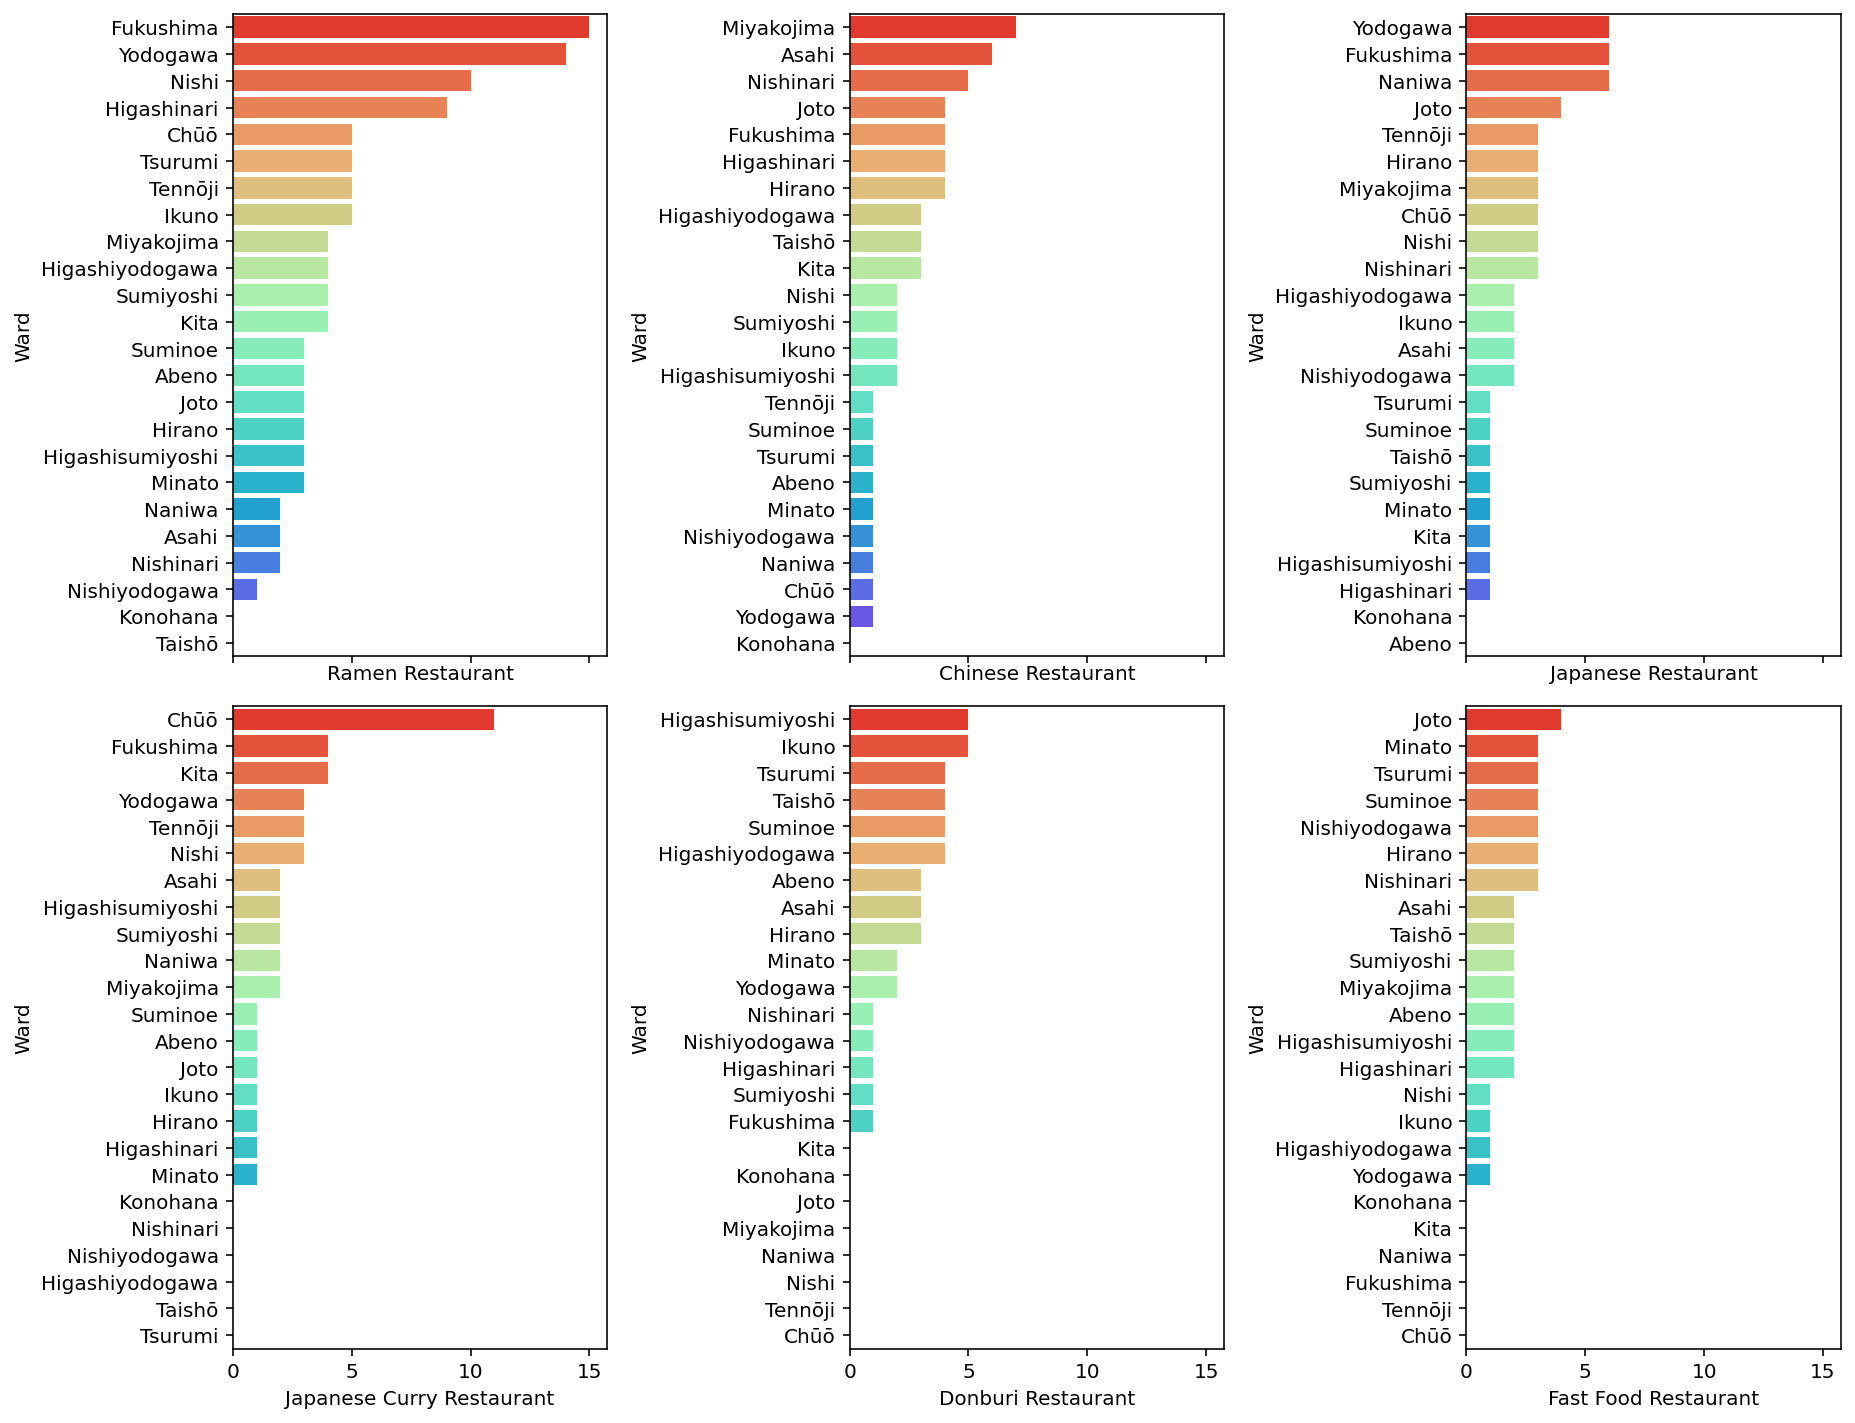

In [0]:
restaurant_top6_list = restaurant_top6.index.values.tolist()
fig, axes =plt.subplots(2, 3, figsize=(13,10), sharex=True)
axes = axes.flatten()
for ax, category in zip(axes, restaurant_top6_list):
    data = restaurant_counts[[category]].sort_values([category], ascending=False)[0:24]
    pal = sns.color_palette("rainbow", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))
plt.tight_layout()
plt.show()

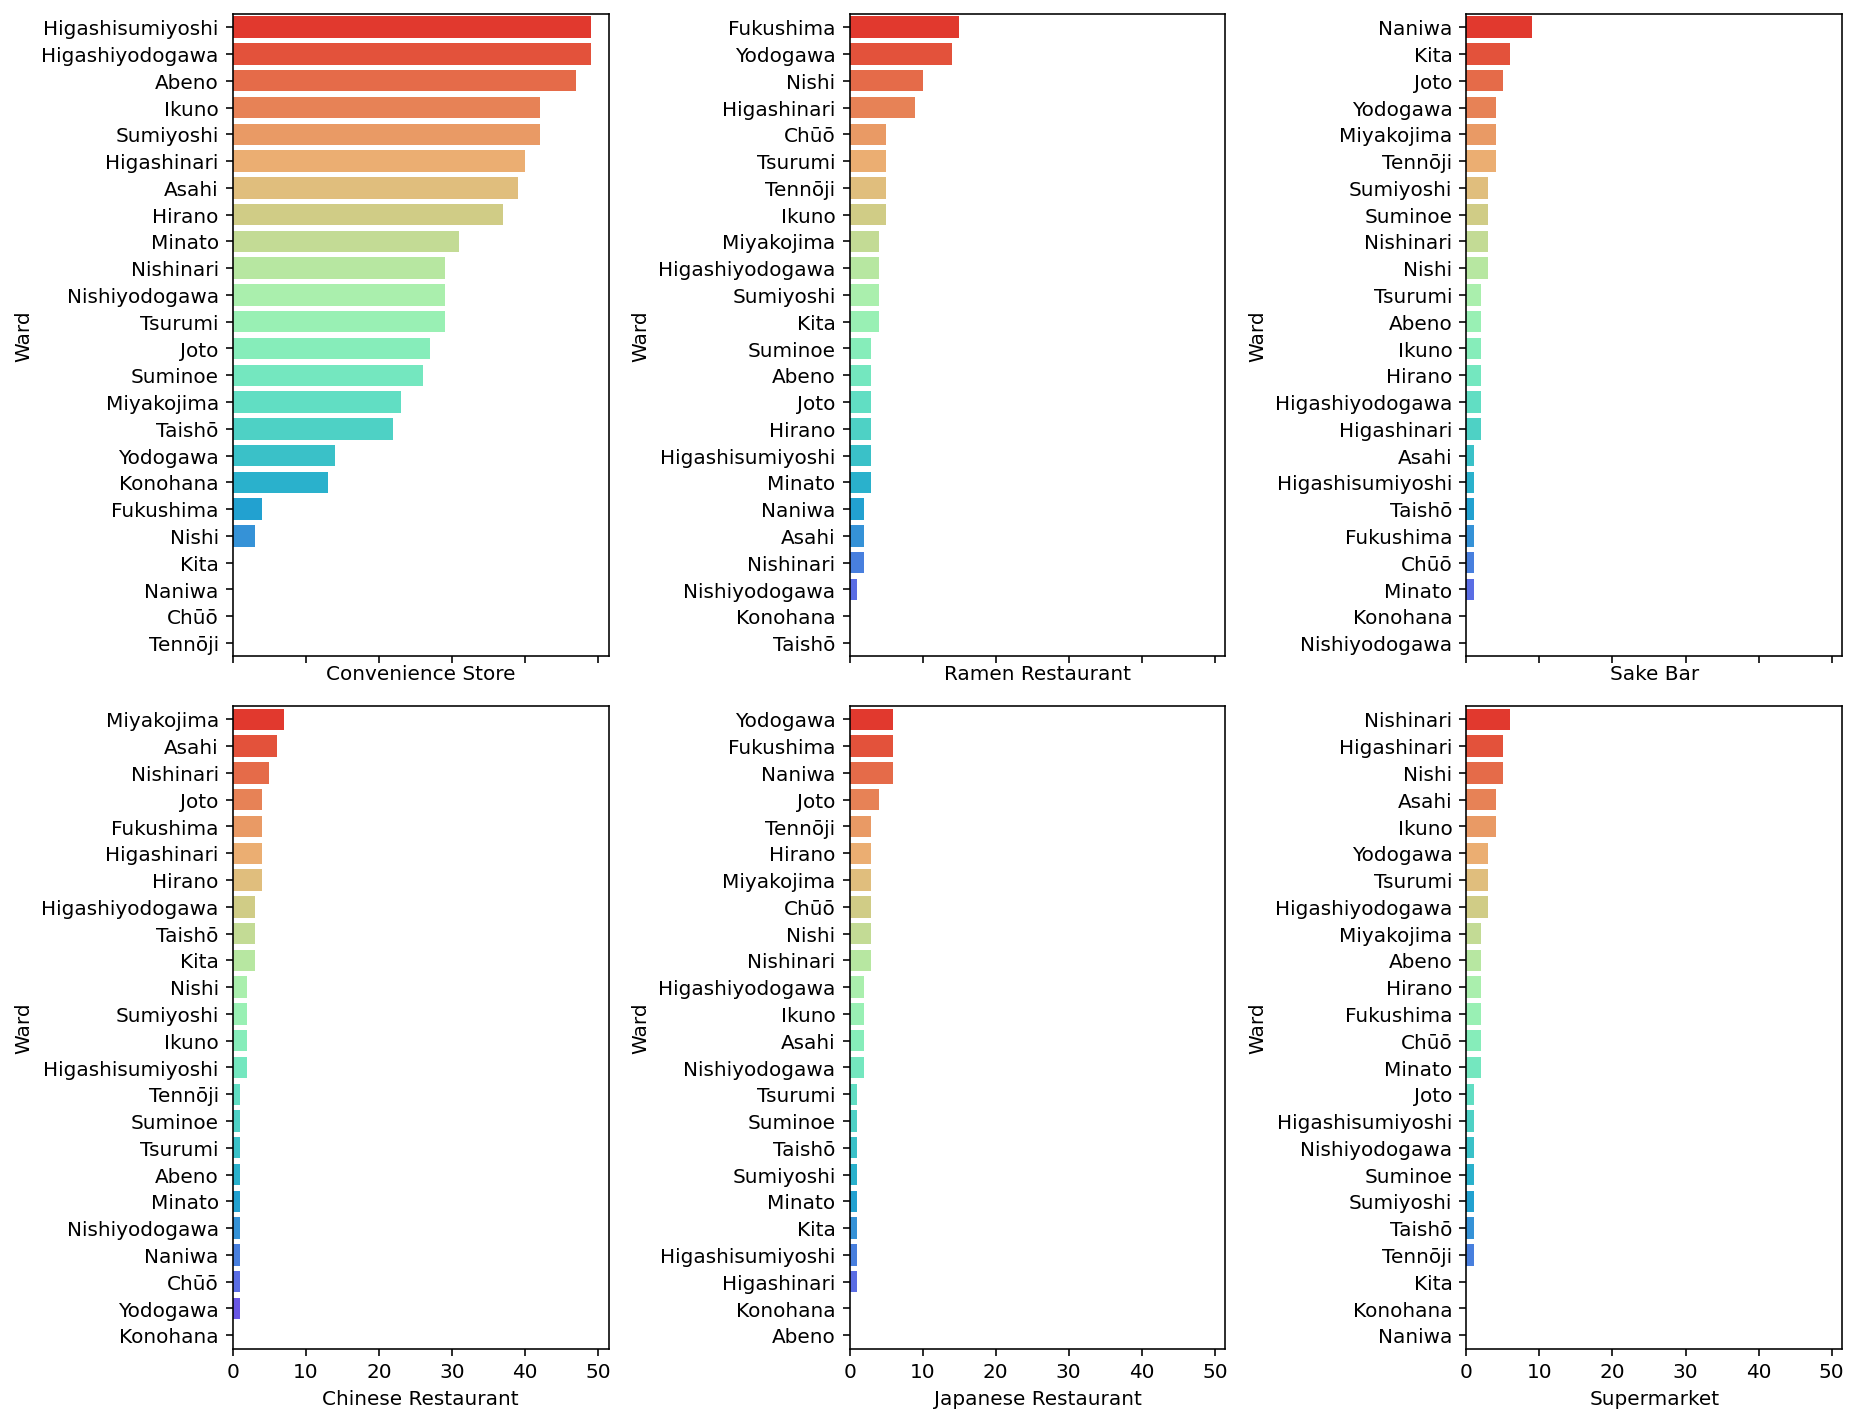

In [0]:
venue_top6_list = venue_top6.index.values.tolist()
fig, axes =plt.subplots(2, 3, figsize=(13,10), sharex=True)
axes = axes.flatten()
for ax, category in zip(axes, venue_top6_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:24]
    pal = sns.color_palette("rainbow", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))
plt.tight_layout()
plt.show()

Investigate the 10 most common restaurant categories in each Ward

In [0]:
restaurant_grouped = osaka_onehot.groupby('Ward').mean().reset_index()
restaurant_grouped.head()

,Ward,American Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Dim Sum Restaurant,Donburi Restaurant,Dumpling Restaurant,Fast Food Restaurant,French Restaurant,Halal Restaurant,Hawaiian Restaurant,Indian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kaiseki Restaurant,Korean Restaurant,Kushikatsu Restaurant,Mediterranean Restaurant,Mexican Restaurant,Nabe Restaurant,Okonomiyaki Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Soba Restaurant,Spanish Restaurant,Sri Lankan Restaurant,Sushi Restaurant,Tapas Restaurant,Tempura Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Udon Restaurant,Unagi Restaurant,Vietnamese Restaurant,Yakitori Restaurant,Yoshoku Restaurant
0,Abeno,0.052632,0.000000,0.00000,0.0,0.0,0.052632,0.0,0.157895,0.052632,0.105263,0.0,0.00000,0.0,0.00000,0.000000,0.052632,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.052632,0.157895,0.157895,0.000000,0.00000,0.000000,0.000000,0.000000,0.052632,0.00000,0.052632,0.000000,0.0,0.0,0.000000,0.00,0.0,0.052632,0.000000
1,Asahi,0.000000,0.040000,0.00000,0.0,0.0,0.240000,0.0,0.120000,0.000000,0.080000,0.0,0.00000,0.0,0.00000,0.040000,0.080000,0.080000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.080000,0.040000,0.000000,0.00000,0.000000,0.000000,0.000000,0.120000,0.00000,0.000000,0.000000,0.0,0.0,0.040000,0.04,0.0,0.000000,0.000000
2,Chūō,0.023810,0.047619,0.02381,0.0,0.0,0.023810,0.0,0.000000,0.000000,0.000000,0.0,0.02381,0.0,0.02381,0.047619,0.261905,0.071429,0.0,0.000000,0.0,0.02381,0.023810,0.0,0.023810,0.119048,0.000000,0.000000,0.02381,0.023810,0.023810,0.047619,0.000000,0.02381,0.000000,0.023810,0.0,0.0,0.023810,0.00,0.0,0.000000,0.071429
3,Fukushima,0.000000,0.020408,0.00000,0.0,0.0,0.081633,0.0,0.020408,0.000000,0.000000,0.0,0.00000,0.0,0.00000,0.081633,0.081633,0.122449,0.0,0.020408,0.0,0.00000,0.020408,0.0,0.000000,0.306122,0.000000,0.040816,0.00000,0.040816,0.020408,0.020408,0.020408,0.00000,0.020408,0.020408,0.0,0.0,0.040816,0.00,0.0,0.020408,0.000000
4,Higashinari,0.037037,0.000000,0.00000,0.0,0.0,0.148148,0.0,0.037037,0.000000,0.074074,0.0,0.00000,0.0,0.00000,0.037037,0.037037,0.037037,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.333333,0.074074,0.000000,0.00000,0.000000,0.000000,0.000000,0.074074,0.00000,0.000000,0.000000,0.0,0.0,0.111111,0.00,0.0,0.000000,0.000000


In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [0]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Ward']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common'.format(ind+1))
ward_restaurant_sorted = pd.DataFrame(columns=columns)
ward_restaurant_sorted['Ward'] = restaurant_grouped['Ward']

for ind in np.arange(restaurant_grouped.shape[0]):
    ward_restaurant_sorted.iloc[ind, 1:] = return_most_common_venues(restaurant_grouped.iloc[ind, :], num_top_venues)

ward_restaurant_sorted.head(24)

,Ward,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
0,Abeno,Donburi Restaurant,Ramen Restaurant,Restaurant,Fast Food Restaurant,Japanese Curry Restaurant,Yakitori Restaurant,Okonomiyaki Restaurant,Dumpling Restaurant,Sushi Restaurant,American Restaurant
1,Asahi,Chinese Restaurant,Donburi Restaurant,Sushi Restaurant,Japanese Curry Restaurant,Ramen Restaurant,Fast Food Restaurant,Japanese Restaurant,Udon Restaurant,Restaurant,Unagi Restaurant
2,Chūō,Japanese Curry Restaurant,Ramen Restaurant,Yoshoku Restaurant,Japanese Restaurant,Asian Restaurant,Italian Restaurant,Sri Lankan Restaurant,Shabu-Shabu Restaurant,Brazilian Restaurant,Chinese Restaurant
3,Fukushima,Ramen Restaurant,Japanese Restaurant,Italian Restaurant,Japanese Curry Restaurant,Chinese Restaurant,Udon Restaurant,Seafood Restaurant,Soba Restaurant,Spanish Restaurant,Donburi Restaurant
4,Higashinari,Ramen Restaurant,Chinese Restaurant,Udon Restaurant,Sushi Restaurant,Restaurant,Fast Food Restaurant,American Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant
5,Higashisumiyoshi,Donburi Restaurant,Ramen Restaurant,Japanese Curry Restaurant,Udon Restaurant,Chinese Restaurant,Restaurant,Fast Food Restaurant,Dumpling Restaurant,Japanese Restaurant,Indian Restaurant
6,Higashiyodogawa,Donburi Restaurant,Ramen Restaurant,Chinese Restaurant,Japanese Restaurant,Sushi Restaurant,Dim Sum Restaurant,Yakitori Restaurant,Soba Restaurant,Fast Food Restaurant,Yoshoku Restaurant
7,Hirano,Chinese Restaurant,Japanese Restaurant,Ramen Restaurant,Donburi Restaurant,Fast Food Restaurant,Japanese Curry Restaurant,Udon Restaurant,Italian Restaurant,Sushi Restaurant,Restaurant
8,Ikuno,Ramen Restaurant,Donburi Restaurant,Japanese Restaurant,Chinese Restaurant,Sushi Restaurant,Japanese Curry Restaurant,Italian Restaurant,Udon Restaurant,Okonomiyaki Restaurant,Restaurant
9,Joto,Japanese Restaurant,Chinese Restaurant,Fast Food Restaurant,Restaurant,Ramen Restaurant,Tonkatsu Restaurant,Asian Restaurant,Japanese Curry Restaurant,Udon Restaurant,Italian Restaurant


Investigate the 10 most common venues in each Ward

In [0]:
venue_grouped = osaka2_onehot.groupby('Ward').mean().reset_index()
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Ward']

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common'.format(ind+1))
ward_venue_sorted = pd.DataFrame(columns=columns)
ward_venue_sorted['Ward'] = venue_grouped['Ward']

for ind in np.arange(venue_grouped.shape[0]):
    ward_venue_sorted.iloc[ind, 1:] = return_most_common_venues(venue_grouped.iloc[ind, :], num_top_venues)

ward_venue_sorted.head(24)

,Ward,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
0,Abeno,Convenience Store,Soccer Stadium,Park,Donburi Restaurant,Ramen Restaurant,Train Station,Coffee Shop,Restaurant,Sake Bar,Supermarket
1,Asahi,Convenience Store,Chinese Restaurant,Supermarket,Grocery Store,Train Station,Sushi Restaurant,Park,Donburi Restaurant,Japanese Curry Restaurant,Fast Food Restaurant
2,Chūō,Japanese Curry Restaurant,Coffee Shop,Ramen Restaurant,Bakery,Rock Club,Yoshoku Restaurant,Café,Japanese Restaurant,Pub,Sri Lankan Restaurant
3,Fukushima,Ramen Restaurant,Japanese Restaurant,Café,BBQ Joint,Pizza Place,Chinese Restaurant,Convenience Store,Japanese Curry Restaurant,Italian Restaurant,Bakery
4,Higashinari,Convenience Store,Ramen Restaurant,Supermarket,Chinese Restaurant,Udon Restaurant,Train Station,Discount Store,Pizza Place,Restaurant,Fast Food Restaurant
5,Higashisumiyoshi,Convenience Store,Soccer Stadium,Donburi Restaurant,Ramen Restaurant,Park,Japanese Curry Restaurant,Restaurant,Fast Food Restaurant,Track Stadium,Bakery
6,Higashiyodogawa,Convenience Store,Train Station,Donburi Restaurant,Ramen Restaurant,Chinese Restaurant,Supermarket,Sake Bar,Drugstore,Furniture / Home Store,Japanese Restaurant
7,Hirano,Convenience Store,Chinese Restaurant,Donburi Restaurant,Intersection,Ramen Restaurant,Japanese Restaurant,Fast Food Restaurant,Bus Station,Sake Bar,Park
8,Ikuno,Convenience Store,Donburi Restaurant,Ramen Restaurant,Supermarket,BBQ Joint,Pizza Place,Steakhouse,Chinese Restaurant,Sake Bar,Japanese Restaurant
9,Joto,Convenience Store,BBQ Joint,Sake Bar,Chinese Restaurant,Fast Food Restaurant,Coffee Shop,Restaurant,Japanese Restaurant,Ramen Restaurant,Shopping Mall


Cluster Wards based on the restaurant categories and venue categories

In [0]:
restaurant_grouped_clustering = restaurant_grouped.drop('Ward', 1)
venue_grouped_clustering = venue_grouped.drop('Ward', 1)

Determine the optimal number of clusters for k-means clustering by the silhouette method

In [0]:
sil = []

K_restaurant = range(2,24)
for k in K_restaurant:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(restaurant_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(restaurant_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 

In [0]:
sil2 = []

K_venue = range(2,24)
for k in K_venue:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(venue_grouped_clustering)
    labels = kmeans.labels_
    sil2.append(silhouette_score(venue_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 

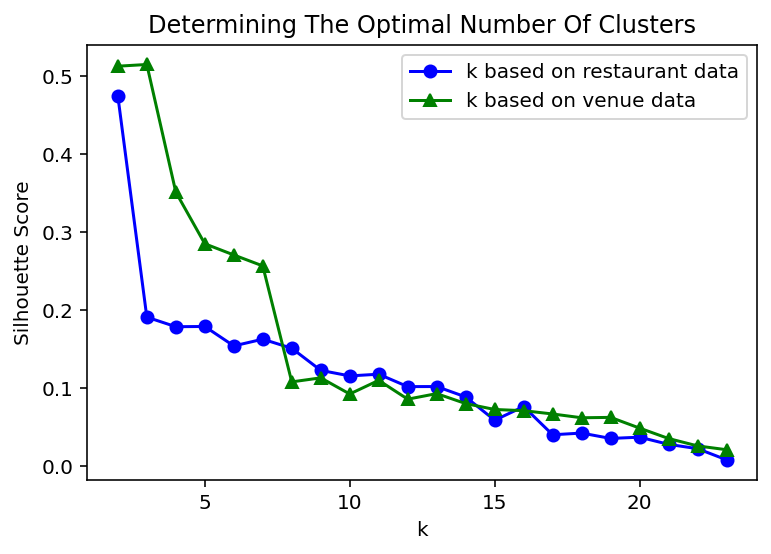

In [0]:
plt.plot(K_restaurant,sil,'bo-',K_venue,sil2,'g^-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.legend(('k based on restaurant data', 'k based on venue data'), loc='upper right')  
plt.title('Determining The Optimal Number Of Clusters');

The highest **Silhouette Score** was obtained at k = 2 to 5 for the green curve, and k = 2 for the blue curve.

Therefore, We will firstly try to use k = 2-5 for K-means clustering based on the venue data, and we will also try k = 2 K-means clustering based on the restaurant data.


For K-means clustering based on the restaurants

In [0]:
kclusters = 2
kmeans_2_res = KMeans(init="k-means++", n_clusters=kclusters, random_state=1).fit(restaurant_grouped_clustering)
print ("Cluster labels based on restaurant data when k = 2:",  kmeans_2_res.labels_[0:24])

Cluster labels based on restaurant data when k = 2: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


When k = 2, only the ward "Konohana" was labeled with a different number.

In [0]:
ward_restaurant_sorted.insert(0, 'Label_k=2', kmeans_2_res.labels_)
ward_restaurant_sorted.head(24)

,Label_k=2,Ward,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
0,0,Abeno,Donburi Restaurant,Ramen Restaurant,Restaurant,Fast Food Restaurant,Japanese Curry Restaurant,Yakitori Restaurant,Okonomiyaki Restaurant,Dumpling Restaurant,Sushi Restaurant,American Restaurant
1,0,Asahi,Chinese Restaurant,Donburi Restaurant,Sushi Restaurant,Japanese Curry Restaurant,Ramen Restaurant,Fast Food Restaurant,Japanese Restaurant,Udon Restaurant,Restaurant,Unagi Restaurant
2,0,Chūō,Japanese Curry Restaurant,Ramen Restaurant,Yoshoku Restaurant,Japanese Restaurant,Asian Restaurant,Italian Restaurant,Sri Lankan Restaurant,Shabu-Shabu Restaurant,Brazilian Restaurant,Chinese Restaurant
3,0,Fukushima,Ramen Restaurant,Japanese Restaurant,Italian Restaurant,Japanese Curry Restaurant,Chinese Restaurant,Udon Restaurant,Seafood Restaurant,Soba Restaurant,Spanish Restaurant,Donburi Restaurant
4,0,Higashinari,Ramen Restaurant,Chinese Restaurant,Udon Restaurant,Sushi Restaurant,Restaurant,Fast Food Restaurant,American Restaurant,Japanese Restaurant,Japanese Curry Restaurant,Italian Restaurant
5,0,Higashisumiyoshi,Donburi Restaurant,Ramen Restaurant,Japanese Curry Restaurant,Udon Restaurant,Chinese Restaurant,Restaurant,Fast Food Restaurant,Dumpling Restaurant,Japanese Restaurant,Indian Restaurant
6,0,Higashiyodogawa,Donburi Restaurant,Ramen Restaurant,Chinese Restaurant,Japanese Restaurant,Sushi Restaurant,Dim Sum Restaurant,Yakitori Restaurant,Soba Restaurant,Fast Food Restaurant,Yoshoku Restaurant
7,0,Hirano,Chinese Restaurant,Japanese Restaurant,Ramen Restaurant,Donburi Restaurant,Fast Food Restaurant,Japanese Curry Restaurant,Udon Restaurant,Italian Restaurant,Sushi Restaurant,Restaurant
8,0,Ikuno,Ramen Restaurant,Donburi Restaurant,Japanese Restaurant,Chinese Restaurant,Sushi Restaurant,Japanese Curry Restaurant,Italian Restaurant,Udon Restaurant,Okonomiyaki Restaurant,Restaurant
9,0,Joto,Japanese Restaurant,Chinese Restaurant,Fast Food Restaurant,Restaurant,Ramen Restaurant,Tonkatsu Restaurant,Asian Restaurant,Japanese Curry Restaurant,Udon Restaurant,Italian Restaurant


Let's see how the K-means clustering based on the venues work. 

In [0]:
kclusters = 2
kmeans_2_venue = KMeans(init="k-means++", n_clusters=kclusters, random_state=1).fit(venue_grouped_clustering)
ward_venue_sorted.insert(0, 'Label_k=2', kmeans_2_venue.labels_)
kclusters = 3
kmeans_3_venue = KMeans(init="k-means++", n_clusters=kclusters, random_state=1).fit(venue_grouped_clustering)
ward_venue_sorted.insert(0, 'Label_k=3', kmeans_3_venue.labels_)
kclusters = 4
kmeans_4_venue = KMeans(init="k-means++", n_clusters=kclusters, random_state=1).fit(venue_grouped_clustering)
ward_venue_sorted.insert(0, 'Label_k=4', kmeans_4_venue.labels_)
kclusters = 5
kmeans_5_venue = KMeans(init="k-means++", n_clusters=kclusters, random_state=1).fit(venue_grouped_clustering)
ward_venue_sorted.insert(0, 'Label_k=5', kmeans_5_venue.labels_)
ward_venue_sorted.head(24)

,Label_k=5,Label_k=4,Label_k=3,Label_k=2,Ward,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
0,1,2,1,0,Abeno,Convenience Store,Soccer Stadium,Park,Donburi Restaurant,Ramen Restaurant,Train Station,Coffee Shop,Restaurant,Sake Bar,Supermarket
1,1,2,1,0,Asahi,Convenience Store,Chinese Restaurant,Supermarket,Grocery Store,Train Station,Sushi Restaurant,Park,Donburi Restaurant,Japanese Curry Restaurant,Fast Food Restaurant
2,2,1,0,1,Chūō,Japanese Curry Restaurant,Coffee Shop,Ramen Restaurant,Bakery,Rock Club,Yoshoku Restaurant,Café,Japanese Restaurant,Pub,Sri Lankan Restaurant
3,4,1,0,1,Fukushima,Ramen Restaurant,Japanese Restaurant,Café,BBQ Joint,Pizza Place,Chinese Restaurant,Convenience Store,Japanese Curry Restaurant,Italian Restaurant,Bakery
4,1,2,1,0,Higashinari,Convenience Store,Ramen Restaurant,Supermarket,Chinese Restaurant,Udon Restaurant,Train Station,Discount Store,Pizza Place,Restaurant,Fast Food Restaurant
5,1,2,1,0,Higashisumiyoshi,Convenience Store,Soccer Stadium,Donburi Restaurant,Ramen Restaurant,Park,Japanese Curry Restaurant,Restaurant,Fast Food Restaurant,Track Stadium,Bakery
6,1,2,1,0,Higashiyodogawa,Convenience Store,Train Station,Donburi Restaurant,Ramen Restaurant,Chinese Restaurant,Supermarket,Sake Bar,Drugstore,Furniture / Home Store,Japanese Restaurant
7,1,2,1,0,Hirano,Convenience Store,Chinese Restaurant,Donburi Restaurant,Intersection,Ramen Restaurant,Japanese Restaurant,Fast Food Restaurant,Bus Station,Sake Bar,Park
8,1,2,1,0,Ikuno,Convenience Store,Donburi Restaurant,Ramen Restaurant,Supermarket,BBQ Joint,Pizza Place,Steakhouse,Chinese Restaurant,Sake Bar,Japanese Restaurant
9,0,0,1,0,Joto,Convenience Store,BBQ Joint,Sake Bar,Chinese Restaurant,Fast Food Restaurant,Coffee Shop,Restaurant,Japanese Restaurant,Ramen Restaurant,Shopping Mall


It looks more reasonable when k = 5.

In [0]:
osaka_merged = osaka_df.join(ward_venue_sorted.set_index('Ward'), on='Wards')
osaka_merged.drop(['Label_k=2','Label_k=3', 'Label_k=4'], axis=1, inplace=True)
osaka_merged.rename(columns={'Label_k=5':'Cluster Labels'}, inplace=True)
osaka_merged.head(24)

,Wards,Kanji,Area,Latitude,Longitude,Cluster Labels,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
0,Abeno,阿倍野区,5.98,34.627501,135.514095,1,Convenience Store,Soccer Stadium,Park,Donburi Restaurant,Ramen Restaurant,Train Station,Coffee Shop,Restaurant,Sake Bar,Supermarket
1,Asahi,旭区,6.32,34.726483,135.546952,1,Convenience Store,Chinese Restaurant,Supermarket,Grocery Store,Train Station,Sushi Restaurant,Park,Donburi Restaurant,Japanese Curry Restaurant,Fast Food Restaurant
2,Chūō,中央区,8.87,34.679846,135.510316,2,Japanese Curry Restaurant,Coffee Shop,Ramen Restaurant,Bakery,Rock Club,Yoshoku Restaurant,Café,Japanese Restaurant,Pub,Sri Lankan Restaurant
3,Fukushima,福島区,4.67,34.692104,135.474812,4,Ramen Restaurant,Japanese Restaurant,Café,BBQ Joint,Pizza Place,Chinese Restaurant,Convenience Store,Japanese Curry Restaurant,Italian Restaurant,Bakery
4,Higashinari,東成区,4.54,34.672912,135.550567,1,Convenience Store,Ramen Restaurant,Supermarket,Chinese Restaurant,Udon Restaurant,Train Station,Discount Store,Pizza Place,Restaurant,Fast Food Restaurant
5,Higashisumiyoshi,東住吉区,9.75,34.615662,135.531096,1,Convenience Store,Soccer Stadium,Donburi Restaurant,Ramen Restaurant,Park,Japanese Curry Restaurant,Restaurant,Fast Food Restaurant,Track Stadium,Bakery
6,Higashiyodogawa,東淀川区,13.27,34.740212,135.517432,1,Convenience Store,Train Station,Donburi Restaurant,Ramen Restaurant,Chinese Restaurant,Supermarket,Sake Bar,Drugstore,Furniture / Home Store,Japanese Restaurant
7,Hirano,平野区,15.28,34.603715,135.559027,1,Convenience Store,Chinese Restaurant,Donburi Restaurant,Intersection,Ramen Restaurant,Japanese Restaurant,Fast Food Restaurant,Bus Station,Sake Bar,Park
8,Ikuno,生野区,8.37,34.653003,135.547722,1,Convenience Store,Donburi Restaurant,Ramen Restaurant,Supermarket,BBQ Joint,Pizza Place,Steakhouse,Chinese Restaurant,Sake Bar,Japanese Restaurant
9,Joto,城東区,8.38,34.693887,135.547769,0,Convenience Store,BBQ Joint,Sake Bar,Chinese Restaurant,Fast Food Restaurant,Coffee Shop,Restaurant,Japanese Restaurant,Ramen Restaurant,Shopping Mall


                Ward  Number of Restaurant
1              Abeno                    19
2              Asahi                    25
3               Chūō                    42
4          Fukushima                    49
5        Higashinari                    27
6   Higashisumiyoshi                    22
7    Higashiyodogawa                    22
8             Hirano                    21
9              Ikuno                    22
10              Joto                    27
11              Kita                    35
12          Konohana                     7
13            Minato                    17
14        Miyakojima                    35
15            Naniwa                    33
16             Nishi                    36
17         Nishinari                    23
18     Nishiyodogawa                    13
19           Suminoe                    22
20         Sumiyoshi                    18
21            Taishō                    14
22           Tennōji                    30
23         

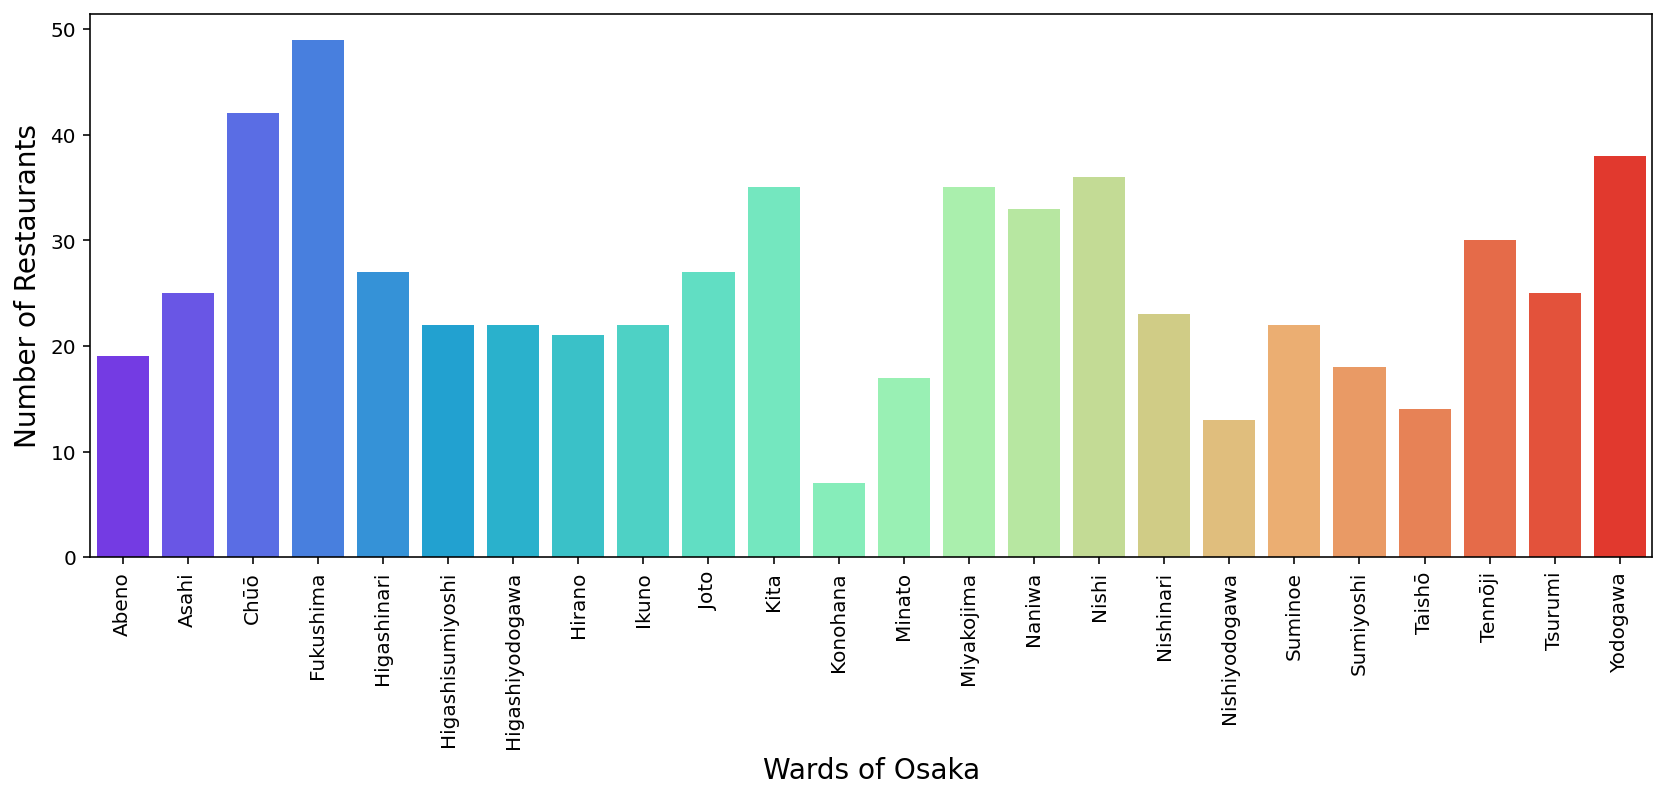

In [0]:
rest_num = Osaka_venues.groupby(['Ward'])['Venue_Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())
rest_num = rest_num.to_frame().reset_index()
rest_num.columns = ['Ward', 'Number of Restaurant']
rest_num.index = np.arange(1, len(rest_num)+1)
print (rest_num)

fig = plt.figure(figsize=(14,5))
bar = sns.barplot(x='Ward', y='Number of Restaurant', data=rest_num, palette="rainbow")
   

bar.set_ylabel("Number of Restaurants", fontsize=14)
bar.set_xlabel("Wards of Osaka", fontsize=14)
bar.set_xticklabels(bar.get_xticklabels(),rotation=90)
plt.show()

In [0]:
list_rest_num = rest_num['Number of Restaurant'].to_list()
list_ward = osaka_merged['Wards'].to_list()

map_clusters = folium.Map(location=[lat_chuoku,lon_chuoku], zoom_start=12)

kclusters = 5
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []

for lat, lon, poi, cluster in zip(osaka_merged['Latitude'], osaka_merged['Longitude'], osaka_merged['Wards'], osaka_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=list_rest_num[list_ward.index(poi)]*0.8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

![ClusterMap](https://raw.githubusercontent.com/Zi-Ao-Huang/IBM_capstone_project/master/Capstone_figure/map_cluster.jpg)

Explore each cluster.

Cluster 1

In [0]:
osaka_cluster1 = osaka_merged.loc[osaka_merged['Cluster Labels'] == 0,osaka_merged.columns[[0]+[1]+list(range(6, osaka_merged.shape[1]))]]
osaka_cluster1

,Wards,Kanji,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
9,Joto,城東区,Convenience Store,BBQ Joint,Sake Bar,Chinese Restaurant,Fast Food Restaurant,Coffee Shop,Restaurant,Japanese Restaurant,Ramen Restaurant,Shopping Mall
13,Miyakojima,都島区,Convenience Store,Chinese Restaurant,Ramen Restaurant,Sake Bar,Sushi Restaurant,Grocery Store,BBQ Joint,Park,Discount Store,Japanese Restaurant
16,Nishinari,西成区,Convenience Store,Supermarket,Chinese Restaurant,Discount Store,Furniture / Home Store,Grocery Store,Fast Food Restaurant,Japanese Restaurant,Sake Bar,Train Station
18,Suminoe,住之江区,Convenience Store,Donburi Restaurant,Sushi Restaurant,Sake Bar,Ramen Restaurant,Fast Food Restaurant,Platform,Drugstore,Restaurant,Pier
20,Taishō,大正区,Convenience Store,Bus Stop,Donburi Restaurant,Chinese Restaurant,Sushi Restaurant,Pizza Place,Golf Driving Range,Park,Grocery Store,Fast Food Restaurant
22,Tsurumi,鶴見区,Convenience Store,Ramen Restaurant,Sushi Restaurant,Coffee Shop,Donburi Restaurant,Fast Food Restaurant,Supermarket,Platform,Noodle House,Steakhouse


Cluster 2

In [0]:
osaka_cluster2 = osaka_merged.loc[osaka_merged['Cluster Labels'] == 1,osaka_merged.columns[[0]+[1]+list(range(6, osaka_merged.shape[1]))]]
osaka_cluster2

,Wards,Kanji,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
0,Abeno,阿倍野区,Convenience Store,Soccer Stadium,Park,Donburi Restaurant,Ramen Restaurant,Train Station,Coffee Shop,Restaurant,Sake Bar,Supermarket
1,Asahi,旭区,Convenience Store,Chinese Restaurant,Supermarket,Grocery Store,Train Station,Sushi Restaurant,Park,Donburi Restaurant,Japanese Curry Restaurant,Fast Food Restaurant
4,Higashinari,東成区,Convenience Store,Ramen Restaurant,Supermarket,Chinese Restaurant,Udon Restaurant,Train Station,Discount Store,Pizza Place,Restaurant,Fast Food Restaurant
5,Higashisumiyoshi,東住吉区,Convenience Store,Soccer Stadium,Donburi Restaurant,Ramen Restaurant,Park,Japanese Curry Restaurant,Restaurant,Fast Food Restaurant,Track Stadium,Bakery
6,Higashiyodogawa,東淀川区,Convenience Store,Train Station,Donburi Restaurant,Ramen Restaurant,Chinese Restaurant,Supermarket,Sake Bar,Drugstore,Furniture / Home Store,Japanese Restaurant
7,Hirano,平野区,Convenience Store,Chinese Restaurant,Donburi Restaurant,Intersection,Ramen Restaurant,Japanese Restaurant,Fast Food Restaurant,Bus Station,Sake Bar,Park
8,Ikuno,生野区,Convenience Store,Donburi Restaurant,Ramen Restaurant,Supermarket,BBQ Joint,Pizza Place,Steakhouse,Chinese Restaurant,Sake Bar,Japanese Restaurant
12,Minato,港区,Convenience Store,Hotel,Train Station,Fast Food Restaurant,Discount Store,Ramen Restaurant,Supermarket,Restaurant,Pizza Place,Donburi Restaurant
17,Nishiyodogawa,西淀川区,Convenience Store,Train Station,Grocery Store,Fast Food Restaurant,Intersection,Clothing Store,Japanese Restaurant,Electronics Store,Supermarket,Furniture / Home Store
19,Sumiyoshi,住吉区,Convenience Store,Train Station,Ramen Restaurant,Sake Bar,Japanese Curry Restaurant,BBQ Joint,Grocery Store,Café,Clothing Store,Restaurant


Cluster 3

In [0]:
osaka_cluster3 = osaka_merged.loc[osaka_merged['Cluster Labels'] == 2,osaka_merged.columns[[0]+[1]+list(range(6, osaka_merged.shape[1]))]]
osaka_cluster3

,Wards,Kanji,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
2,Chūō,中央区,Japanese Curry Restaurant,Coffee Shop,Ramen Restaurant,Bakery,Rock Club,Yoshoku Restaurant,Café,Japanese Restaurant,Pub,Sri Lankan Restaurant
10,Kita,北区,Café,Sake Bar,Dessert Shop,Ramen Restaurant,Japanese Curry Restaurant,Bar,BBQ Joint,Kushikatsu Restaurant,Chinese Restaurant,Shopping Mall
14,Naniwa,浪速区,Sake Bar,Japanese Restaurant,Udon Restaurant,BBQ Joint,Café,Coffee Shop,Yoshoku Restaurant,Restaurant,Rock Club,Ramen Restaurant
21,Tennōji,天王寺区,Electronics Store,Kushikatsu Restaurant,Okonomiyaki Restaurant,Ramen Restaurant,Café,Hotel,Bar,Sake Bar,Hobby Shop,Coffee Shop


Cluster 4

In [0]:
osaka_cluster4 = osaka_merged.loc[osaka_merged['Cluster Labels'] == 3,osaka_merged.columns[[0]+[1]+list(range(6, osaka_merged.shape[1]))]]
osaka_cluster4

,Wards,Kanji,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
11,Konohana,此花区,Theme Park Ride / Attraction,Convenience Store,Intersection,Gift Shop,Theme Park,Hotel,Harbor / Marina,American Restaurant,Pizza Place,Smoke Shop


Cluster 5

In [0]:
osaka_cluster5 = osaka_merged.loc[osaka_merged['Cluster Labels'] == 4,osaka_merged.columns[[0]+[1]+list(range(6, osaka_merged.shape[1]))]]
osaka_cluster5

,Wards,Kanji,1st Most Common,2nd Most Common,3rd Most Common,4th Most Common,5th Most Common,6th Most Common,7th Most Common,8th Most Common,9th Most Common,10th Most Common
3,Fukushima,福島区,Ramen Restaurant,Japanese Restaurant,Café,BBQ Joint,Pizza Place,Chinese Restaurant,Convenience Store,Japanese Curry Restaurant,Italian Restaurant,Bakery
15,Nishi,西区,Ramen Restaurant,Supermarket,Café,Japanese Restaurant,Sake Bar,Train Station,Convenience Store,Bakery,Japanese Curry Restaurant,Dessert Shop
23,Yodogawa,淀川区,Ramen Restaurant,Convenience Store,Japanese Restaurant,Discount Store,Sake Bar,Coffee Shop,Supermarket,Japanese Curry Restaurant,Donut Shop,Donburi Restaurant
